# ROMY & FUR - Overview

## Load Libraries

In [37]:
import os, sys
import pickle
import matplotlib.pyplot as plt
import numpy as np

from pprint import pprint

from obspy import UTCDateTime, read_inventory
from scipy.signal import welch
from pandas import read_pickle, DataFrame

from functions.get_time_intervals import __get_time_intervals
from functions.load_bathymetry import __load_bathymetry

In [38]:
import sys
sys.path.append('..')

In [39]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [40]:
config = {}

# test 2
# config['tbeg'] = UTCDateTime("2024-02-01")
# config['tend'] = UTCDateTime("2024-03-15")

# test 3 - longterm
# config['tbeg'] = UTCDateTime("2023-09-23")
# config['tend'] = UTCDateTime("2024-05-31")

# moving event
# config['tbeg'] = UTCDateTime("2024-03-01")
# config['tend'] = UTCDateTime("2024-03-03")

# moving event
# config['tbeg'] = UTCDateTime("2024-02-20")
# config['tend'] = UTCDateTime("2024-03-01")

# september data
config['tbeg'] = UTCDateTime("2024-09-15")
config['tend'] = UTCDateTime("2024-09-16")


config['path'] = data_path+"VelocityChanges/data/statistics/"
config['path_all'] = data_path+"VelocityChanges/data/all/"

config['path_to_figs'] = data_path+"VelocityChanges/figures/"

config['path_to_bathy_data'] = data_path+"VelocityChanges/data/bathymetry/"

config['romy_lon'], config['romy_lat'] = 11.275501, 48.162941


In [41]:
dates = __get_time_intervals(config['tbeg'] ,config['tend'], interval_seconds=86400, interval_overlap=0)

baz1, baz2, baz3, baz4 = np.array([]), np.array([]), np.array([]), np.array([])
std1, std2, std3, std4 = np.array([]), np.array([]), np.array([]), np.array([])

vel_std1, vel_std2, vel_std3, vel_std4 = np.array([]), np.array([]), np.array([]), np.array([])
vel1, vel2, vel3, vel4 = np.array([]), np.array([]), np.array([]), np.array([])

ttt = np.array([])

for _n, (d1, d2) in enumerate(dates):

    # filename = f"VC_BAZ_{d1.date}_{d2.date}.pkl"
    filename = f"VC_BAZ_{d1.date}.pkl"

    if os.path.isfile(config['path']+filename):
        # print(f"loading: {filename}")
        out = read_pickle(config['path']+filename)
    else:
        print(f"-> no file for {filename}")

    # print(out.keys())

    try:
        baz1 = np.append(baz1, out['baz_tangent'])
        baz2 = np.append(baz2, out['baz_bf'])
        baz3 = np.append(baz3, out['baz_love'])
        baz4 = np.append(baz4, out['baz_rayleigh'])

        std1 = np.append(std1, out['baz_tangent_std'])
        std2 = np.append(std2, out['baz_bf_std'])
        std3 = np.append(std3, out['baz_love_std'])
        std4 = np.append(std4, out['baz_rayleigh_std'])

        vel2 = np.append(vel2, out['vel_bf'])
        vel3 = np.append(vel3, out['vel_love_max'])
        vel4 = np.append(vel4, out['vel_rayleigh_max'])

        # vel_std2 = np.append(vel_std2, out['vel_bf_std'])
        vel_std3 = np.append(vel_std3, out['vel_love_std'])
        vel_std4 = np.append(vel_std4, out['vel_rayleigh_std'])

        ttt = np.append(ttt, out['time'])

    except:
        print(f" -> skipping: {filename}")
        continue

## remove nan values based on time array
bad = []
for _i, tt in enumerate(ttt):
    if str(type(tt)) != "<class 'obspy.core.utcdatetime.UTCDateTime'>":
        bad.append(_i)

ttt = np.delete(ttt, bad)
baz1 = np.delete(baz1, bad)
baz2 = np.delete(baz2, bad)
baz3 = np.delete(baz3, bad)
baz4 = np.delete(baz4, bad)
std1 = np.delete(std1, bad)
std2 = np.delete(std2, bad)
std3 = np.delete(std3, bad)
std4 = np.delete(std4, bad)


In [42]:
std1 = np.array([1 if s < 1 else s for s in std1])
std2 = np.array([1 if s < 1 else s for s in std2])
std3 = np.array([1 if s < 1 else s for s in std3])


## Plotting

/tmp/ipykernel_1551348/4039073196.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[Nrow-1].set_xticklabels(tcklbls)


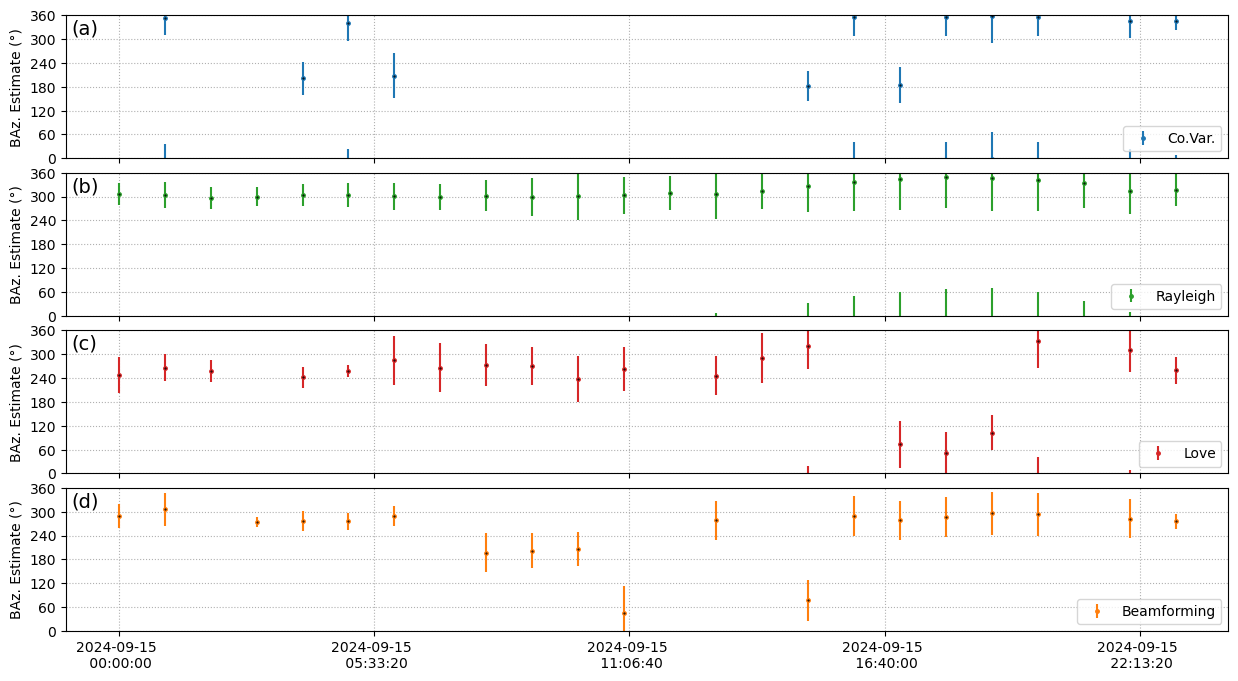

In [43]:
def __makeplot():

    Nrow, Ncol = 4, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    t_axis = (ttt-ttt[0])

    ms = 5

    ax[0].errorbar(t_axis, baz1, yerr=std1/2, fmt=".", color="tab:blue", ms=ms, label="Co.Var.")
    ax[1].errorbar(t_axis, baz2, yerr=std2/2, fmt=".", color="tab:green", ms=ms, label="Rayleigh")
    ax[2].errorbar(t_axis, baz3, yerr=std3/2, fmt=".", color="tab:red", ms=ms, label="Love")
    ax[3].errorbar(t_axis, baz4, yerr=std4/2, fmt=".", color="tab:orange", ms=ms, label="Beamforming")

    ax[0].errorbar(t_axis, baz1-360, yerr=std1/2, fmt=".", color="tab:blue", ms=ms)
    ax[1].errorbar(t_axis, baz2-360, yerr=std2/2, fmt=".", color="tab:green", ms=ms)
    ax[2].errorbar(t_axis, baz3-360, yerr=std3/2, fmt=".", color="tab:red", ms=ms)
    ax[3].errorbar(t_axis, baz4-360, yerr=std4/2, fmt=".", color="tab:orange", ms=ms)

    ax[0].errorbar(t_axis, baz1, yerr=0, fmt=".", color="k", ms=1)
    ax[1].errorbar(t_axis, baz2, yerr=0, fmt=".", color="k", ms=1)
    ax[2].errorbar(t_axis, baz3, yerr=0, fmt=".", color="k", ms=1)
    ax[3].errorbar(t_axis, baz4, yerr=0, fmt=".", color="k", ms=1)

    # ax[0].fill_between(t_axis, baz1-std1/2, baz1-std1/2, fmt="k.", color="tab:blue", label="Co.Var.")
    # ax[1].errorbar(t_axis, baz2, yerr=std2/2, fmt="k.", color="tab:green", label="Rayleigh")
    # ax[2].errorbar(t_axis, baz3, yerr=std3/2, fmt="k.", color="tab:red", label="Love")

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=4)
        ax[_n].set_ylim(0, 360)
        ax[_n].set_yticks(np.arange(0, 360+60, 60))
        ax[_n].set_ylabel("BAz. Estimate (°)")
        # ax[_n].set_xlim(left=0)

    # ax[Nrow-1].set_xlabel(f"Time (days) from {config['tbeg'].date} UTC", fontsize=font)

    ## add dates for x-axis
    ref_date = config['tbeg']
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    for _k, ll in enumerate(['(a)', '(b)', '(c)', '(d)']):
        ax[_k].text(.005, .97, ll, ha='left', va='top', transform=ax[_k].transAxes, fontsize=font+2)



    plt.show();
    return fig

fig = __makeplot();

# fig.savefig(config['path_to_figs']+f"BAZ_timeline_{config['tbeg'].date}_{config['tend'].date}.png", format="png", dpi=150, bbox_inches='tight')


In [26]:
from functions.smoothing import __smooth

In [27]:
nn = 6

baz1_smth = __smooth(baz1, nn)
baz2_smth = __smooth(baz2, nn)
baz3_smth = __smooth(baz3, nn)
baz4_smth = __smooth(baz4, nn)

std1_smth = __smooth(std1, nn)
std2_smth = __smooth(std2, nn)
std3_smth = __smooth(std3, nn)
std4_smth = __smooth(std4, nn)


In [14]:
def __makeplot2():

    Nrow, Ncol = 4, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    t_axis = (ttt-ttt[0])

    ms = 5

    ax[0].errorbar(t_axis, baz1_smth, yerr=std1_smth/2, fmt=".", color="tab:blue", ms=ms, label="Co.Var.")
    ax[1].errorbar(t_axis, baz2_smth, yerr=std2_smth/2, fmt=".", color="tab:green", ms=ms, label="Rayleigh")
    ax[2].errorbar(t_axis, baz3_smth, yerr=std3_smth/2, fmt=".", color="tab:red", ms=ms, label="Love")
    ax[3].errorbar(t_axis, baz4_smth, yerr=std4_smth/2, fmt=".", color="tab:orange", ms=ms, label="Beamforming")

    ax[0].errorbar(t_axis, baz1_smth-360, yerr=std1_smth/2, fmt=".", color="tab:blue", ms=ms)
    ax[1].errorbar(t_axis, baz2_smth-360, yerr=std2_smth/2, fmt=".", color="tab:green", ms=ms)
    ax[2].errorbar(t_axis, baz3_smth-360, yerr=std3_smth/2, fmt=".", color="tab:red", ms=ms)
    ax[3].errorbar(t_axis, baz4_smth-360, yerr=std4_smth/2, fmt=".", color="tab:orange", ms=ms)

    ax[0].errorbar(t_axis, baz1_smth, yerr=0, fmt=".", color="k", ms=1)
    ax[1].errorbar(t_axis, baz2_smth, yerr=0, fmt=".", color="k", ms=1)
    ax[2].errorbar(t_axis, baz3_smth, yerr=0, fmt=".", color="k", ms=1)
    ax[3].errorbar(t_axis, baz4_smth, yerr=0, fmt=".", color="k", ms=1)

    # ax[0].fill_between(t_axis, baz1-std1/2, baz1-std1/2, fmt="k.", color="tab:blue", label="Co.Var.")
    # ax[1].errorbar(t_axis, baz2, yerr=std2/2, fmt="k.", color="tab:green", label="Rayleigh")
    # ax[2].errorbar(t_axis, baz3, yerr=std3/2, fmt="k.", color="tab:red", label="Love")

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=4)
        ax[_n].set_ylim(0, 360)
        ax[_n].set_yticks(np.arange(0, 360+60, 60))
        ax[_n].set_ylabel("BAz. Estimate (°)")
        # ax[_n].set_xlim(left=0)

    # ax[Nrow-1].set_xlabel(f"Time (days) from {config['tbeg'].date} UTC", fontsize=font)

    ## add dates for x-axis
    ref_date = config['tbeg']
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    plt.show();
    return fig

# fig = __makeplot2();

# fig.savefig(config['path_to_figs']+f"BAZ_timeline_{config['tbeg'].date}_{config['tend'].date}_smooth.png", format="png", dpi=150, bbox_inches='tight')


In [11]:
# df_test = DataFrame()
# df_test['time'] = ttt
# df_test['baz'] = baz1
# df_test['std'] = std1

# # df_test.dropna(inplace=True)

# t_axis = (ttt-ttt[0])/86400

# # plt.fill_between(t_axis, baz1, yerr=std1/2, fmt=".", color="tab:blue", label="Co.Var.")
# plt.fill_between(df_test.time, df_test.baz-0.5*df_test.std, df_test.baz+0.5*df_test.std, color="tab:blue")

## Circular Plot

In [12]:
def circular_hist(ax, x, nbins=72, density=True, offset=0, gaps=True, weights=None):
    """
    Produce a circular histogram of angles on ax.

    Parameters
    ----------
    ax : matplotlib.axes._subplots.PolarAxesSubplot
        axis instance created with subplot_kw=dict(projection='polar').

    x : array
        Angles to plot, expected in units of radians.

    bins : int, optional
        Defines the number of equal-width bins in the range. The default is 16.

    density : bool, optional
        If True plot frequency proportional to area. If False plot frequency
        proportional to radius. The default is True.

    offset : float, optional
        Sets the offset for the location of the 0 direction in units of
        radians. The default is 0.

    gaps : bool, optional
        Whether to allow gaps between bins. When gaps = False the bins are
        forced to partition the entire [-pi, pi] range. The default is True.

    Returns
    -------
    n : array or list of arrays
        The number of values in each bin.

    bins : array
        The edges of the bins.

    patches : `.BarContainer` or list of a single `.Polygon`
        Container of individual artists used to create the histogram
        or list of such containers if there are multiple input datasets.
    """
    # Wrap angles to [-pi, pi)
    x = (x+np.pi) % (2*np.pi) - np.pi

    # Force bins to partition entire circle
    if not gaps:
        nbins = np.linspace(-np.pi, np.pi, num=nbins+1)

    # Bin data and record counts
    if weights is not None:
        n, bins = np.histogram(x, bins=nbins, range=(-np.pi, np.pi), weights=weights)
    else:
        n, bins = np.histogram(x, bins=nbins, range=(-np.pi, np.pi))

    # Compute width of each bin
    widths = np.diff(bins)

    # By default plot frequency proportional to area
    if density:
        # Area to assign each bin
        area = n / x.size
        # Calculate corresponding bin radius
        radius = (area/np.pi) ** .5
    # Otherwise plot frequency proportional to radius
    else:
        radius = n

    # Plot data on ax
    patches = ax.bar(bins[:-1], radius, zorder=2, align='edge', width=widths,
                     edgecolor='darkred', fill=False, linewidth=0.7)

    # Set the direction of the zero angle
    # ax.set_theta_offset(offset)
    ax.set_theta_zero_location("N")  # theta=0 at the top

    ax.set_theta_direction(-1)  # theta increasing clockwise

    ax.grid(zorder=0)

    # Remove ylabels for area plots (they are mostly obstructive)
    if density:
        ax.set_yticks([])

    return n, bins, patches

In [13]:
def __makeplot_polar(weight=False):

    import matplotlib.pyplot as plt
    import numpy as np

    font = 12

    # weight = False

    # Construct figure and axis to plot on
    fig, ax = plt.subplots(2, 2, subplot_kw=dict(projection='polar'), figsize=(8, 8))

    plt.subplots_adjust(wspace=0.3)

    if weight:
        circular_hist(ax[0,0], np.deg2rad(baz1), weights=1/np.deg2rad(std1), density=True)
        circular_hist(ax[0,1], np.deg2rad(baz2), weights=1/np.deg2rad(std2), density=True)
        circular_hist(ax[1,0], np.deg2rad(baz3), weights=1/np.deg2rad(std3), density=True)
        circular_hist(ax[1,1], np.deg2rad(baz4), weights=1/np.deg2rad(std4), density=True)
    else:
        circular_hist(ax[0,0], np.deg2rad(baz1), density=False)
        circular_hist(ax[0,1], np.deg2rad(baz2), density=False)
        circular_hist(ax[1,0], np.deg2rad(baz3), density=False)
        circular_hist(ax[1,1], np.deg2rad(baz4), density=False)

    ax[0,0].set_title("(a) Co.Var.", loc="left")
    ax[0,1].set_title("(b) Beamforming", loc="left")
    ax[1,0].set_title("(c) Love", loc="left")
    ax[1,1].set_title("(d) Rayleigh", loc="left")

    for i in range(2):
        for j in range(2):
            ax[i,j].grid(color="k", zorder=0, ls="--", alpha=0.5)

    plt.suptitle(f"Backazimuth Estimation:  BW.ROMY - GR.FUR  ({config['tbeg'].date} - {config['tend'].date})", fontsize=font+1)

    plt.show();
    return fig

# fig = __makeplot_polar()

# fig.savefig(config['path_to_figs']+f"BAZ_polar_{config['tbeg'].date}_{config['tend'].date}.png", format="png", dpi=150, bbox_inches='tight')


## Map Plot

In [14]:
def __load_bathymetry(path_to_data, box=(-180, -90, 180, 90)):

    from numpy import array
    from glob import glob
    import cartopy.io.shapereader as shpreader
    import matplotlib

    # Read shapefiles, sorted by depth
    shp_dict = {}
    files = glob(path_to_data+'*.shp')

    files.sort()

    depths = []
    for f in files:
        depth = '-' + f.split('_')[-1].split('.')[0]  # depth from file name
        depths.append(depth)
        bbox = box  # (x0, y0, x1, y1)
        nei = shpreader.Reader(f, bbox=bbox)
        shp_dict[depth] = nei

    depths_str = array(depths)[::-1]  # sort from surface to bottom

    # Construct a discrete colormap with colors corresponding to each depth
    depths = depths_str.astype(int)
    N = len(depths)
    nudge = 0.01  # shift bin edge slightly to include data
    boundaries = [min(depths)] + sorted(depths+nudge)  # low to high
    norm = matplotlib.colors.BoundaryNorm(boundaries, N)
    blues_cm = matplotlib.colormaps['Blues_r'].resampled(N)
    colors_depths = blues_cm(norm(depths))

    out = {}
    out['depths'] = depths
    out['shp_dict'] = shp_dict
    out['colors_depths'] = colors_depths
    out['blues_cm'] = blues_cm
    out['depths_str'] = depths_str
    out['norm'] = norm

    return out

In [15]:
box = [config['romy_lon']-40, config['romy_lon']+40, config['romy_lat']-40, config['romy_lat']+40]

out_bath = __load_bathymetry(config['path_to_bathy_data'], (box[0], box[2], box[1], box[3]))


In [16]:
def __makeplot_maps(weights=True, density=False):

    import gc
    import matplotlib.colors
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import matplotlib.pyplot as mpl
    import cartopy.feature as cfeature

    romy_lon = 11.275501
    romy_lat = 48.162941

    flatMap = ccrs.PlateCarree()

    resolution = '50m'

    box = [romy_lon-40, romy_lon+40, romy_lat-40, romy_lat+40]

    ## load bathymetry data
    out_bath = __load_bathymetry(config['path_to_bathy_data'], (box[0], box[2], box[1], box[3]))

    font = 12

    fig = plt.figure(figsize=(10, 10), dpi=96)

    fig.subplots_adjust(hspace=0.2, wspace=0.2)

    ## ________________________________________________
    ## CoVar

    ax0 = fig.add_subplot(221, projection=flatMap)

    ax0.imshow(np.tile(np.array([[cfeature.COLORS['water'] * 255]], dtype=np.uint8), [2, 2, 1]),
              origin='upper',
              transform=ccrs.PlateCarree(),
              extent=box
             )

    # ax0.add_feature(cfeature.NaturalEarthFeature('physical', 'land', resolution, edgecolor='black', facecolor="lightgrey"))

    ax00 = fig.add_subplot(221, projection='polar')

    if weights:
        circular_hist(ax00, np.deg2rad(baz1), weights=1/np.deg2rad(std1), density=density)
    else:
        circular_hist(ax00, np.deg2rad(baz1), density=density)

    ax00.patch.set_alpha(0.)
    ax00.grid(color="k", ls="--", alpha=0.5)

    ## plot bathymetry
    for i, _depth_str in enumerate(out_bath['depths_str']):
        ax0.add_geometries(out_bath['shp_dict'][_depth_str].geometries(),
                           crs=ccrs.PlateCarree(),
                           color=out_bath['colors_depths'][i]
                           )

    sm = plt.cm.ScalarMappable(cmap=out_bath['blues_cm'], norm=out_bath['norm'])
    ax0.set_rasterized(True)

    ax0.add_feature(cfeature.NaturalEarthFeature('physical', 'land', resolution, edgecolor='black', lw=0.5, facecolor="lightgrey"))
    # ax0.add_feature(cfeature.LAND, color='grey')
    ax0.coastlines(lw=0.5, resolution=resolution)
    ax0.set_rasterized(True)


    ## ________________________________________________
    ## Beamforming

    ax1 = fig.add_subplot(222, projection=flatMap)

    ax1.imshow(np.tile(np.array([[cfeature.COLORS['water'] * 255]], dtype=np.uint8), [2, 2, 1]),
              origin='upper',
              transform=ccrs.PlateCarree(),
              extent=box
             )

    # ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', resolution, edgecolor='black', facecolor="lightgrey"))


    ax01 = fig.add_subplot(222, projection='polar')

    if weights:
        circular_hist(ax01, np.deg2rad(baz2), weights=1/np.deg2rad(std2), density=density)
    else:
        circular_hist(ax01, np.deg2rad(baz2), density=density)

    ax01.patch.set_alpha(0.)
    ax01.grid(color="k", ls="--", alpha=0.5)

    ## plot bathymetry
    for i, _depth_str in enumerate(out_bath['depths_str']):
        ax1.add_geometries(out_bath['shp_dict'][_depth_str].geometries(),
                           crs=ccrs.PlateCarree(),
                           color=out_bath['colors_depths'][i]
                           )

    sm = plt.cm.ScalarMappable(cmap=out_bath['blues_cm'], norm=out_bath['norm'])
    ax1.set_rasterized(True)

    ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', resolution, edgecolor='black', lw=0.5, facecolor="lightgrey"))
    # ax1.add_feature(cfeature.LAND, color='grey')
    ax1.coastlines(lw=0.5, resolution=resolution)
    ax1.set_rasterized(True)


    ## ________________________________________________
    ## Love

    ax2 = fig.add_subplot(223, projection=flatMap)

    ax2.imshow(np.tile(np.array([[cfeature.COLORS['water'] * 255]], dtype=np.uint8), [2, 2, 1]),
              origin='upper',
              transform=ccrs.PlateCarree(),
              extent=box
             )

    # ax2.add_feature(cfeature.NaturalEarthFeature('physical', 'land', resolution, edgecolor='black', facecolor="lightgrey"))

    ax02 = fig.add_subplot(223, projection='polar')

    if weights:
        circular_hist(ax02, np.deg2rad(baz3), weights=1/np.deg2rad(std3), density=density)
    else:
        circular_hist(ax02, np.deg2rad(baz3), density=density)

    ax02.patch.set_alpha(0.)
    ax02.grid(color="k", ls="--", alpha=0.5)


    ## plot bathymetry
    for i, _depth_str in enumerate(out_bath['depths_str']):
        ax2.add_geometries(out_bath['shp_dict'][_depth_str].geometries(),
                           crs=ccrs.PlateCarree(),
                           color=out_bath['colors_depths'][i]
                           )

    sm = plt.cm.ScalarMappable(cmap=out_bath['blues_cm'], norm=out_bath['norm'])
    ax2.set_rasterized(True)

    ax2.add_feature(cfeature.NaturalEarthFeature('physical', 'land', resolution, edgecolor='black', lw=0.5, facecolor="lightgrey"))
    # ax2.add_feature(cfeature.LAND, color='grey')
    ax2.coastlines(lw=0.5, resolution=resolution)
    ax2.set_rasterized(True)


    ## ________________________________________________
    ## Rayleigh

    ax3 = fig.add_subplot(224, projection=flatMap)


    ax3.imshow(np.tile(np.array([[cfeature.COLORS['water'] * 255]], dtype=np.uint8), [2, 2, 1]),
              origin='upper',
              transform=ccrs.PlateCarree(),
              extent=box
             )

    # ax3.add_feature(cfeature.NaturalEarthFeature('physical', 'land', resolution, edgecolor='black', facecolor=cfeature.COLORS['land']))
    # ax3.add_feature(cfeature.NaturalEarthFeature('physical', 'land', resolution, edgecolor='black', facecolor="lightgrey"))

    ax03 = fig.add_subplot(224, projection='polar')

    if weights:
        circular_hist(ax03, np.deg2rad(baz4), weights=1/np.deg2rad(std4), density=density)
    else:
        circular_hist(ax03, np.deg2rad(baz4), density=density)



    ax03.patch.set_alpha(0.)
    ax03.grid(color="k", ls="--", alpha=0.5)

    ## plot bathymetry
    for i, _depth_str in enumerate(out_bath['depths_str']):
        ax3.add_geometries(out_bath['shp_dict'][_depth_str].geometries(),
                           crs=ccrs.PlateCarree(),
                           color=out_bath['colors_depths'][i]
                           )

    sm = plt.cm.ScalarMappable(cmap=out_bath['blues_cm'], norm=out_bath['norm'])
    ax3.set_rasterized(True)

    ax3.add_feature(cfeature.NaturalEarthFeature('physical', 'land', resolution, edgecolor='black', lw=0.5, facecolor="lightgrey"))
    # ax3.add_feature(cfeature.LAND, color='grey')
    ax3.coastlines(lw=0.5, resolution=resolution)
    ax3.set_rasterized(True)



    ax0.set_title("(a) Co-Variance", pad=15, loc="left", fontsize=font)
    ax1.set_title("(b) Beamforming", pad=15, loc="left", fontsize=font)
    ax2.set_title("(c) Love waves", pad=15, loc="left", fontsize=font)
    ax3.set_title("(d) Rayleigh waves", pad=15, loc="left", fontsize=font)

    plt.suptitle(f"Backazimuth Estimation:  BW.ROMY - GR.FUR  ({config['tbeg'].date} - {config['tend'].date})", fontsize=font+1, y=0.95)

    gc.collect()

    plt.show();
    return fig

/tmp/ipykernel_1155965/2277364237.py:165: RuntimeWarning: divide by zero encountered in divide
  circular_hist(ax03, np.deg2rad(baz4), weights=1/np.deg2rad(std4), density=density)


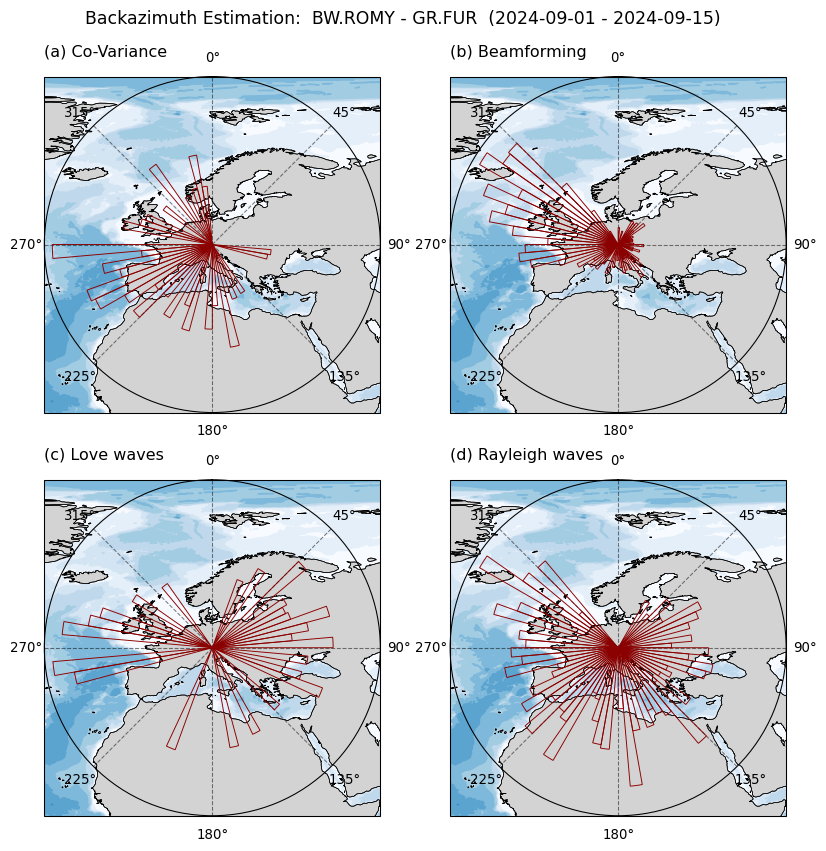

In [17]:
density = True

fig = __makeplot_maps(weights=True, density=density)

if density:
    fig.savefig(config['path_to_figs']+f"BAZ_maps_{config['tbeg'].date}_{config['tend'].date}_density.png", format="png", dpi=150, bbox_inches='tight')
else:
    fig.savefig(config['path_to_figs']+f"BAZ_maps_{config['tbeg'].date}_{config['tend'].date}.png", format="png", dpi=150, bbox_inches='tight')


## Velocities

In [ ]:
# def __makeplot4():

#     Nrow, Ncol = 2, 1

#     font = 12

#     fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 5), sharex=True)

#     plt.subplots_adjust(hspace=0.1)

#     time_scaling = 1/86400

#     ax[0].scatter(df_love.time_relative*time_scaling, df_love.vel,
#                   s=10**df_love.cc, c=df_love.cc, label="Love")

#     ax[1].scatter(df_rayleigh.time_relative*time_scaling, df_rayleigh.vel,
#                   s=10**df_rayleigh.cc, c=df_rayleigh.cc, label="Rayleigh")


#     for _n in range(Nrow):
#         ax[_n].grid(ls=":", zorder=0, which="both")
#         ax[_n].legend(loc=4)
#         ax[_n].set_ylim(0, 5000)
#         # ax[_n].set_yticks(np.arange(0, 360+60, 60))
#         ax[_n].set_ylabel("Phase Velocity (m/s)")
#         ax[_n].set_xlim(left=0)
#         # ax[_n].set_yscale("log")

#     ax[Nrow-1].set_xlabel(f"Time (days) from {config['tbeg'].date} UTC", fontsize=font)

#     plt.show();
#     return fig

In [ ]:
# fig = __makeplot4();

# fig.savefig(config['path_to_figs']+f"BAZ_timeline_{config['tbeg'].date}_{config['tend'].date}.png", format="png", dpi=150, bbox_inches='tight')

In [ ]:
# df_rayleigh = DataFrame()

# df_rayleigh['time'] = ttt
# df_rayleigh['cc'] = cc_rayleigh
# df_rayleigh['vel'] = vel_rayleigh

# df_rayleigh = df_rayleigh.dropna(subset=['time']).reset_index()

# df_rayleigh['time_relative'] = df_rayleigh.time - df_rayleigh.time.iloc[0]


# df_love = DataFrame()

# df_love['time'] = ttt
# df_love['cc'] = cc_love
# df_love['vel'] = vel_love

# df_love = df_love.dropna(subset=['time']).reset_index()

# df_love['time_relative'] = df_love.time - df_love.time.iloc[0]

In [ ]:
# def __makeplot():

#     Nrow, Ncol = 2, 1

#     font = 12

#     fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 5), sharex=True)

#     plt.subplots_adjust(hspace=0.1)

#     time_scaling = 1/86400

#     ax[0].scatter(df_love.time_relative*time_scaling, df_love.vel,
#                   s=10**df_love.cc, c=df_love.cc, label="Love")

#     ax[1].scatter(df_rayleigh.time_relative*time_scaling, df_rayleigh.vel,
#                   s=10**df_rayleigh.cc, c=df_rayleigh.cc, label="Rayleigh")


#     for _n in range(Nrow):
#         ax[_n].grid(ls=":", zorder=0, which="both")
#         ax[_n].legend(loc=4)
#         ax[_n].set_ylim(0, 5000)
#         # ax[_n].set_yticks(np.arange(0, 360+60, 60))
#         ax[_n].set_ylabel("Phase Velocity (m/s)")
#         ax[_n].set_xlim(left=0)
#         # ax[_n].set_yscale("log")

#     ax[Nrow-1].set_xlabel(f"Time (days) from {config['tbeg'].date} UTC", fontsize=font)

#     plt.show();
#     return fig

# fig = __makeplot();

# # fig.savefig(config['path_to_figs']+f"BAZ_timeline_{config['tbeg'].date}_{config['tend'].date}.png", format="png", dpi=150, bbox_inches='tight')


In [ ]:
# def __makeplot():

#     Nrow, Ncol = 2, 1

#     font = 12

#     fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

#     plt.subplots_adjust(hspace=0.1)

#     t_axis = (ttt-ttt[0])/86400

#     ax[0].scatter(t_axis, vel_love, s=20**cc_love, c=cc_love, label="Love")
#     ax[1].scatter(t_axis, vel_rayleigh, s=20**cc_rayleigh, c=cc_rayleigh, label="Rayleigh")
#     # ax[2].scatter(t_axis, vel_bf, fmt=".", color="tab:orange", label="Beamforming")


#     for _n in range(Nrow):
#         ax[_n].grid(ls=":", zorder=0)
#         ax[_n].legend(loc=4)
#         # ax[_n].set_ylim(0, 360)
#         # ax[_n].set_yticks(np.arange(0, 360+60, 60))
#         ax[_n].set_ylabel("Phase Velocity (m/s)")
#         ax[_n].set_xlim(left=0)
#         ax[_n].set_yscale("log")

#     ax[Nrow-1].set_xlabel(f"Time (days) from {config['tbeg'].date} UTC", fontsize=font)

#     plt.show();
#     return fig

# fig = __makeplot();

# # fig.savefig(config['path_to_figs']+f"BAZ_timeline_{config['tbeg'].date}_{config['tend'].date}.png", format="png", dpi=150, bbox_inches='tight')


In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# font = 12

# # Construct figure and axis to plot on
# fig, ax = plt.subplots(1, 3, subplot_kw=dict(projection='polar'), figsize=(15, 5))

# circular_hist(ax[0], np.deg2rad(baz1), weights=1/np.deg2rad(std1), density=True)
# # circular_hist(ax[0], np.deg2rad(baz1), density=True)
# ax[0].set_title("Co.Var.")

# circular_hist(ax[1], np.deg2rad(baz2), weights=1/np.deg2rad(std2), density=True)
# # circular_hist(ax[1], np.deg2rad(baz2), density=True)
# ax[1].set_title("Rayleigh")

# circular_hist(ax[2], np.deg2rad(baz3), weights=1/np.deg2rad(std3), density=True)
# # circular_hist(ax[2], np.deg2rad(baz3), density=True)

# ax[2].set_title("Love")

# for _i in range(3):
#     ax[_i].grid(color="k", alpha=0.5, ls="--", zorder=0)

# plt.suptitle(f"Backazimuth Estimation:  BW.ROMY - GR.FUR  ({config['tbeg'].date} - {config['tend'].date})", fontsize=font+1)

# plt.show();

In [ ]:
# import gc
# import matplotlib.colors
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
# import matplotlib.pyplot as mpl
# import cartopy.feature as cfeature

# romy_lon = 11.275501
# romy_lat = 48.162941

# flatMap = ccrs.PlateCarree()
# resolution = '50m'

# fig = plt.figure(figsize=(12, 6), dpi=96)

# ax = fig.add_subplot(111, projection=flatMap)

# ax.imshow(np.tile(np.array([[cfeature.COLORS['water'] * 255]], dtype=np.uint8), [2, 2, 1]),
#           origin='upper',
#           transform=ccrs.PlateCarree(),
#           extent=[romy_lon-35, romy_lon+35, romy_lat-35, romy_lat+35]
#          )

# ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', resolution, edgecolor='black', facecolor=cfeature.COLORS['land']))

# ax1 = fig.add_subplot(111, projection='polar', )

# # circular_hist(ax1, np.deg2rad(baz1), weights=1/np.deg2rad(std1), density=True)
# circular_hist(ax1, np.deg2rad(baz1), density=True)

# # ax1.set_title("Co.Var.")

# # ax1.get_xaxis().set_visible(False)
# # ax1.get_yaxis().set_visible(False)
# ax1.patch.set_alpha(0.)
# # ax1.axis("off")

# ax1.grid(color="k", zorder=0)

# gc.collect()

# plt.show();